In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
sys.path.append(os.getcwd())
import scanpy as sc
import pandas as pd
import anndata as ad

In [2]:
os.chdir('/data/lyx/hubs/SpaTD/stdgcn/benchmark_data/stereo_seq/zebrafish_rawdata/')

In [3]:
data_dir = "/data/lyx/hubs/SpaTD/stdgcn/benchmark_data/stereo_seq/zebrafish/"

In [4]:
adata_st = ad.read_h5ad("./spatial_sixtime_slice_stereoseq.h5ad")

In [5]:
adata_st_s1 = adata_st[adata_st.obs.slice==1].copy()
adata_st_s11 = adata_st[adata_st.obs.slice==11].copy()
adata_st_s10 = adata_st[adata_st.obs.slice==10].copy()
adata_st_s8_12 = adata_st[adata_st.obs.time=="12hpf"].copy()
adata_st_s8_18 = adata_st[adata_st.obs.time=="18hpf"].copy()
adata_st_s4 = adata_st[adata_st.obs.slice==4].copy()

In [5]:
adata_sc1 = ad.read_h5ad("zf3_scRNA.h5ad")
adata_sc4 = ad.read_h5ad("zf24_scRNA.h5ad")
adata_sc8_12 = ad.read_h5ad("zf12_scRNA.h5ad")
adata_sc8_18 = ad.read_h5ad("zf18_scRNA.h5ad")
adata_sc10 = ad.read_h5ad("zf5_scRNA.h5ad")
adata_sc11 = ad.read_h5ad("zf10_scRNA.h5ad")

In [7]:
sc.pp.calculate_qc_metrics(adata_st_s8_12, percent_top=None, log1p=False, inplace=True)

In [10]:
adata_st_s8_12

AnnData object with n_obs × n_vars = 2081 × 26628
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'spatial_x', 'spatial_y', 'slice', 'bin_annotation', 'colors', 'layer_annotation', 'layer_colors', 'time', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts', 'scale.data'

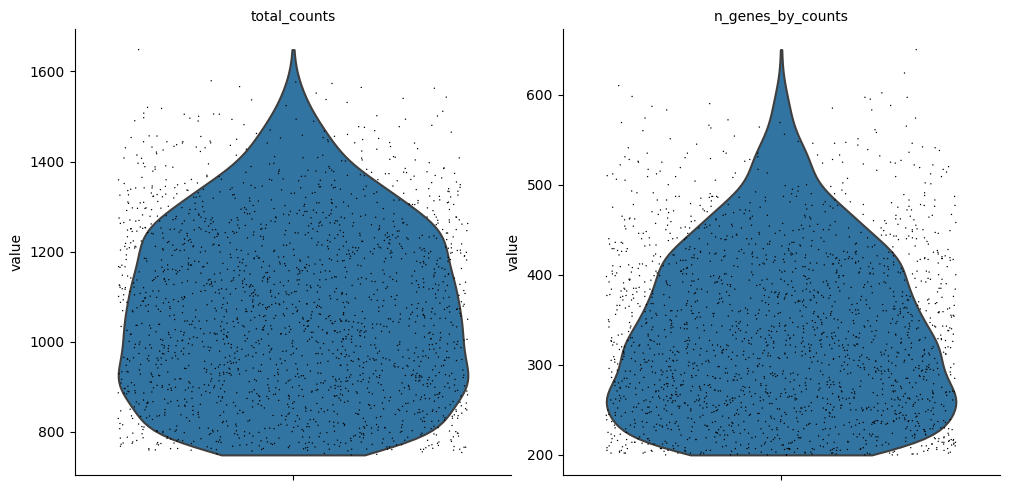

In [9]:
sc.pl.violin(adata_st_s8_12, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

In [129]:
st8_18 = ad.read_h5ad('st8_18_use.h5ad')
sc8_18 = ad.read_h5ad('sc8_18_use.h5ad')

In [130]:
adata_st_s8_12 =adata_st_s8_18.copy()
adata_sc8_12 = adata_sc8_18.copy()

In [131]:
adata_st_s8_12 = adata_st_s8_12[adata_st_s8_12.obs_names.isin(st8_18.obs_names)]
adata_sc8_12 = adata_sc8_12[adata_sc8_12.obs_names.isin(sc8_18.obs_names)]

In [132]:
adata_st_s8_12.obs.bin_annotation = st8_18.obs.bin_annotation
adata_sc8_12.obs.celltype_new = sc8_18.obs.celltype_new

In [133]:
genes= list(set(adata_sc8_12.var_names) & set(adata_st_s8_12.var_names))

In [134]:
adata_st_s8_12 =adata_st_s8_12[:,genes]
adata_sc8_12 =adata_sc8_12[:,genes]

In [328]:
#adata = adata_st_s8_12.concatenate(adata_sc8_12)
adata = st8_18.concatenate(sc_other)
adata.obs['batch'] = ''

In [329]:
adata.obs['batch'] = ['ST' for i in range(st8_18.obs.shape[0])]+['sc' for i in range(sc_other.obs.shape[0])]
#adata.obs['batch'] = ['ST' for i in range(adata_st_s8_12.obs.shape[0])]+['sc' for i in range(adata_sc8_12.obs.shape[0])]

In [330]:
adata.var['mt'] = adata.var_names.str.startswith('^mt') # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.regress_out(adata, ['total_counts'])
sc.pp.scale(adata, max_value=100)
sc.tl.pca(adata, svd_solver='arpack')

In [331]:
import scanpy.external as sce
sce.pp.harmony_integrate(adata, 'batch')

2023-10-10 23:10:45,699 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-10-10 23:10:54,307 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-10-10 23:10:54,481 - harmonypy - INFO - Iteration 1 of 10
2023-10-10 23:10:56,319 - harmonypy - INFO - Iteration 2 of 10
2023-10-10 23:10:58,336 - harmonypy - INFO - Converged after 2 iterations


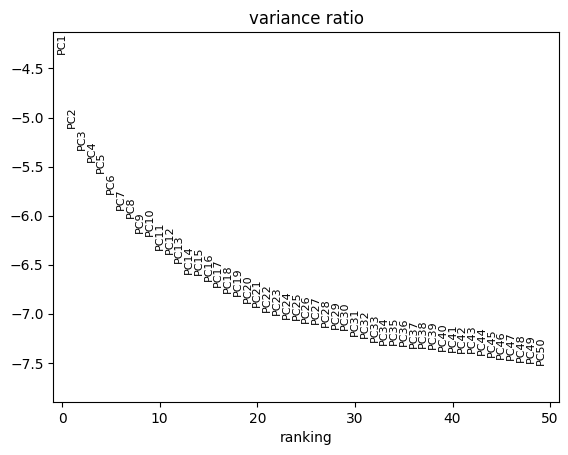

In [332]:
pca_harmony=adata.obsm['X_pca_harmony']
pca=adata.obsm['X_pca']
adata.obsm['X_pca']=pca_harmony
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50,save='.s8_t18.harmony.svg')

In [333]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

In [334]:
sc.tl.umap(adata)

In [335]:
sc.tl.leiden(adata,resolution=0.2)

In [336]:
adata.obs['cell_type'] = ''
#adata.obs['cell_type'] = adata_st_s8_12.obs.bin_annotation.to_list()+adata_sc8_12.obs.celltype_new.to_list()
adata.obs['cell_type'] = st8_18.obs.bin_annotation.to_list()+sc_other.obs.celltype_new.to_list()

In [337]:
adata.obs['batch_cell_type'] = '' 
adata.obs['batch_cell_type'] = [str(adata.obs.batch[i]) +'_'+ str(adata.obs.cell_type[i]) for i in range(adata.obs.shape[0])]

In [211]:
idx = adata.obs[adata.obs.leiden.isin(['6'])]

In [212]:
idx = idx.index[idx.batch=='sc']

In [213]:
adata = adata[~adata.obs_names.isin(idx.to_list())]

In [338]:
confusion_matrix = pd.crosstab(adata.obs['batch_cell_type'],adata.obs['leiden'])
print(confusion_matrix)

leiden                                           0    1    2    3    4    5  \
batch_cell_type                                                               
ST_Angioblastic_Mesenchymal_Cell                 1    0   33    0    0    2   
ST_Erythroid_Lineage_Cell                        3   40    0    0    0  191   
ST_Hatching Gland                                0    0    0    0    0    0   
ST_Nervous_System                                0    0  419    1    0    0   
ST_Neural_Crest                                  0    0  191    0    2    7   
ST_Notochord                                     1    5   42    0    0  346   
ST_Periderm_and_YSL                              0    0    0    0    0    3   
ST_Pronephros                                    0    0    0    0    0    0   
ST_Segmental_Plate_and_Tail_Bud                  2    5    3    0    0    1   
sc_Cardiovascular System                         0    0    0    1   31    0   
sc_Central Nervous System                        0  

In [228]:
adata.obs[adata.obs.batch_cell_type=='ST_Segmental_Plate_and_Tail_Bud']

,orig.ident,nCount_RNA,nFeature_RNA,seurat_clusters,spatial_x,spatial_y,slice,bin_annotation,colors,layer_annotation,...,celltype_new,clusters,batch,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,cell_type,batch_cell_type
DNB_-6910_7875,DNB,2089,780,1.0,8898.25,905.0,8.0,Segmental_Plate_and_Tail_Bud,#6E9BC5,Mesoderm,...,NaN,NaN,ST,775,1744.839478,0.0,0.0,10,Segmental_Plate_and_Tail_Bud,ST_Segmental_Plate_and_Tail_Bud
DNB_-6895_7440,DNB,2593,943,16.0,8463.25,920.0,8.0,Segmental_Plate_and_Tail_Bud,#6E9BC5,Mesoderm,...,NaN,NaN,ST,936,1929.830811,0.0,0.0,8,Segmental_Plate_and_Tail_Bud,ST_Segmental_Plate_and_Tail_Bud
DNB_-6865_7440,DNB,2103,823,16.0,8463.25,950.0,8.0,Segmental_Plate_and_Tail_Bud,#6E9BC5,Mesoderm,...,NaN,NaN,ST,820,1831.003784,0.0,0.0,8,Segmental_Plate_and_Tail_Bud,ST_Segmental_Plate_and_Tail_Bud
DNB_-6835_7455,DNB,2136,818,16.0,8478.25,980.0,8.0,Segmental_Plate_and_Tail_Bud,#6E9BC5,Mesoderm,...,NaN,NaN,ST,812,1814.337646,0.0,0.0,8,Segmental_Plate_and_Tail_Bud,ST_Segmental_Plate_and_Tail_Bud
DNB_-6160_7080,DNB,1396,615,1.0,8103.25,1655.0,8.0,Segmental_Plate_and_Tail_Bud,#6E9BC5,Mesoderm,...,NaN,NaN,ST,614,1576.958252,0.0,0.0,1,Segmental_Plate_and_Tail_Bud,ST_Segmental_Plate_and_Tail_Bud
DNB_-7030_7740,DNB,1636,663,1.0,8763.25,785.0,8.0,Segmental_Plate_and_Tail_Bud,#6E9BC5,Mesoderm,...,NaN,NaN,ST,658,1617.404541,0.0,0.0,10,Segmental_Plate_and_Tail_Bud,ST_Segmental_Plate_and_Tail_Bud
DNB_-6820_7470,DNB,1260,539,16.0,8493.25,995.0,8.0,Segmental_Plate_and_Tail_Bud,#6E9BC5,Mesoderm,...,NaN,NaN,ST,537,1417.094971,0.0,0.0,8,Segmental_Plate_and_Tail_Bud,ST_Segmental_Plate_and_Tail_Bud
DNB_-6310_7260,DNB,800,397,6.0,8283.25,1505.0,8.0,Segmental_Plate_and_Tail_Bud,#6E9BC5,Mesoderm,...,NaN,NaN,ST,395,1204.777100,0.0,0.0,5,Segmental_Plate_and_Tail_Bud,ST_Segmental_Plate_and_Tail_Bud
DNB_-6700_7395,DNB,867,431,10.0,8418.25,1115.0,8.0,Segmental_Plate_and_Tail_Bud,#6E9BC5,Mesoderm,...,NaN,NaN,ST,429,1263.419922,0.0,0.0,9,Segmental_Plate_and_Tail_Bud,ST_Segmental_Plate_and_Tail_Bud
DNB_-6040_7680,DNB,633,336,1.0,8703.25,1775.0,8.0,Segmental_Plate_and_Tail_Bud,#6E9BC5,Mesoderm,...,NaN,NaN,ST,334,1077.073730,0.0,0.0,5,Segmental_Plate_and_Tail_Bud,ST_Segmental_Plate_and_Tail_Bud


In [314]:
st8_18 = adata_st_s8_12.copy()
sc8_18 = adata_sc8_12.copy()
sc8_18.obs.celltype_new = sc8_18.obs.celltype_new.to_list()
st8_18.obs.bin_annotation = st8_18.obs.bin_annotation.to_list()

In [315]:
#adata.obs_names = adata.obs_names.str[:-2]
sc8_18 = sc8_18[sc8_18.obs_names.str[:-2].isin(adata.obs_names)].copy()
st8_18 = st8_18[st8_18.obs_names.str[:-2].isin(adata.obs_names)].copy()

In [322]:
sc8_18.obs.loc[sc8_18.obs.celltype_new.isin(['Central Nervous System','Primary Neuron']), 
                     'celltype_new'] = 'Nervous_System'
st8_18.obs.loc[st8_18.obs.bin_annotation.isin(['Nervous System','Forebrain']), 
                     'bin_annotation'] = 'Nervous_System'

sc8_18.obs.loc[sc8_18.obs.celltype_new.isin(['Cardiovascular System']), 
                     'celltype_new'] = 'Angioblastic_Mesenchymal_Cell'
st8_18.obs.loc[st8_18.obs.bin_annotation.isin(['Angioblastic Mesenchymal Cell']), 
                     'bin_annotation'] = 'Angioblastic_Mesenchymal_Cell'

st8_18.obs.loc[st8_18.obs.bin_annotation.isin(['Somite']), 
                     'bin_annotation'] = 'Segmental_Plate_and_Tail_Bud'
sc8_18.obs.loc[sc8_18.obs.celltype_new.isin(['Periderm_and_YSL']), 
                     'celltype_new'] = 'Neural_Crest'

sc8_18.obs.loc[sc8_18.obs.celltype_new.isin(['Erythroid Lineage Cell','Periderm_krt17']), 
                     'celltype_new'] = 'Erythroid_Lineage_Cell'
st8_18.obs.loc[st8_18.obs.bin_annotation.isin(['Erythroid Lineage Cell']), 
                     'bin_annotation'] = 'Erythroid_Lineage_Cell'

In [353]:
set(st8_18.obs.bin_annotation.unique()) &set(sc8_18.obs.celltype_new.unique())

{'Angioblastic_Mesenchymal_Cell',
 'Erythroid_Lineage_Cell',
 'Hatching Gland',
 'Nervous_System',
 'Neural_Crest',
 'Notochord',
 'Pronephros',
 'Segmental_Plate_and_Tail_Bud'}

In [342]:
st8_18 = st8_18[~st8_18.obs.bin_annotation.isin(['Immature Eye, Midbrain','Periderm_and_YSL'])].copy()
sc8_18 = sc8_18[~sc8_18.obs.celltype_new.isin(['Integument','Lateral Plate Mesoderm, Endothelial Cell',
                                              'Periderm_and_YSL'])].copy()

In [354]:
st8_18.obs.bin_annotation.value_counts()

Notochord                        758
Nervous_System                   614
Neural_Crest                     528
Segmental_Plate_and_Tail_Bud     395
Erythroid_Lineage_Cell           356
Angioblastic_Mesenchymal_Cell    155
Hatching Gland                   130
Pronephros                        16
Name: bin_annotation, dtype: int64

In [355]:
sc8_18.obs.celltype_new.value_counts()

Nervous_System                   1952
Neural_Crest                     1416
Erythroid_Lineage_Cell            635
Angioblastic_Mesenchymal_Cell     423
Segmental_Plate_and_Tail_Bud      401
Notochord                         376
Pronephros                        107
Hatching Gland                     50
Name: celltype_new, dtype: int64

In [345]:
sc_other = adata_sc8_18[~adata_sc8_18.obs_names.isin(sc8_18.obs_names)].copy()

In [347]:
sc_other = sc_other[sc_other.obs.celltype_new.isin(['Hatching Gland','Pronephros','Neural Crest'])].copy()

In [348]:
sc8_18 = sc8_18.concatenate(sc_other)

In [352]:
sc8_18.obs.loc[sc8_18.obs.celltype_new=='Neural Crest','celltype_new'] = 'Neural_Crest'

In [356]:
sc8_18.obs.loc[sc8_18.obs.celltype_new=='Hatching Gland','celltype_new'] = 'Hatching_Gland'
st8_18.obs.loc[st8_18.obs.bin_annotation=='Hatching Gland','bin_annotation'] = 'Hatching_Gland'

In [361]:
sc8_18.obs_names = sc8_18.obs_names.str[:-2]

In [362]:
st8_18.write_h5ad('st8_18_use.h5ad')
sc8_18.write_h5ad('sc8_18_use.h5ad')

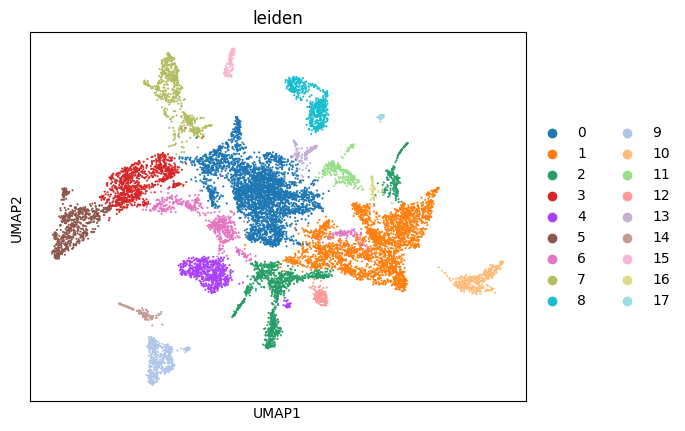

In [95]:
sc.pl.umap(adata, color='leiden')

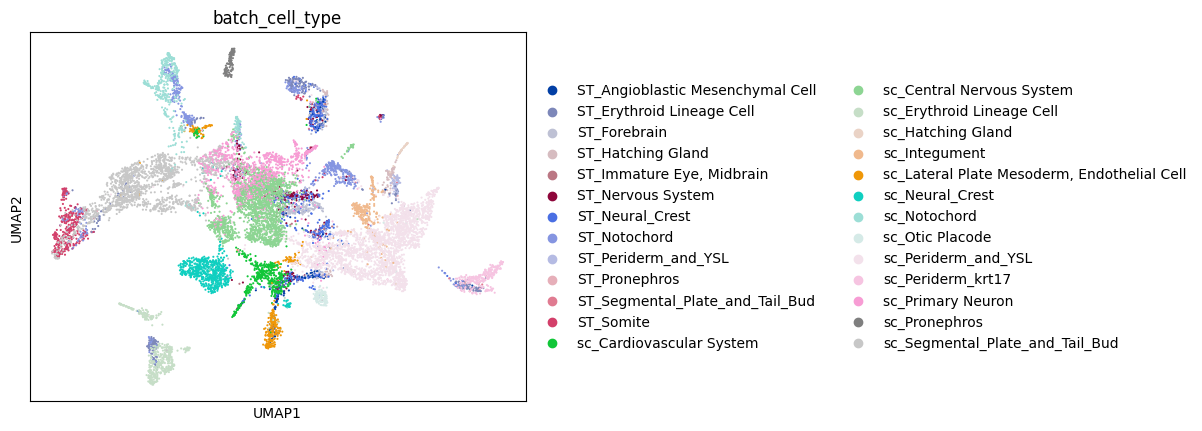

In [107]:
sc.pl.umap(adata, color='batch_cell_type')

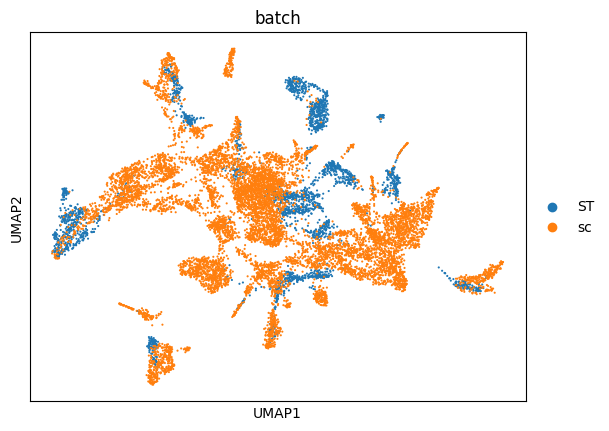

In [93]:
sc.pl.umap(adata, color='batch')

In [381]:
adata_st_s8_12 = ad.read_h5ad('st8_18_use.h5ad')
adata_sc8_12 = ad.read_h5ad('sc8_18_use.h5ad')

In [382]:
data = pd.DataFrame(adata_sc8_12.layers['counts'].todense())

In [383]:
data.columns = adata_sc8_12.var_names
data.index = pd.Index(adata_sc8_12.obs_names)

In [384]:
data.to_csv('../zebrafish/sc_data/zebrafish_time18_slice8_sc_data.tsv',sep="\t")

In [385]:
data = pd.DataFrame(adata_st_s8_12.layers['counts'].todense())

In [386]:
data.columns = adata_st_s8_12.var_names
data.index = pd.Index(adata_st_s8_12.obs_names)

In [387]:
data.to_csv('time18_slice8_ST_data.tsv',sep="\t")

In [388]:
data.shape

(2952, 23052)

In [389]:
label = adata_sc8_12.obs[["celltype_new"]]

In [390]:
label.columns = ['bio_celltype']

In [391]:
label.to_csv(os.path.join(data_dir,"sc_data",'time18_sc_label.tsv'),sep="\t")

In [392]:
loc = adata_st_s8_12.obs[['spatial_x', 'spatial_y']]

In [393]:
loc.columns = ['x','y']
loc.to_csv('time18_slice8_coordinates.csv')

In [394]:
adata_st_s8_12.obs.to_csv('time18_slice8_annotation.csv')

In [395]:
prefix = "zebrafish"
res = 50
idx1="time18_slice8"

In [50]:
"{0}_{1}_sc_data.tsv".format(prefix,idx1)

'zebrafish_time12_slice8_sc_data.tsv'

In [51]:
"{0}_{1}_data_{2}.tsv".format(prefix,res,idx1)

'zebrafish_50_data_time12_slice8.tsv'

In [52]:
"{0}_{1}_coordinates_{2}.tsv".format(prefix,res,idx1)

'zebrafish_50_coordinates_time12_slice8.tsv'

In [53]:
"{0}_{1}_ground_truth_{2}.tsv".format(prefix,res,idx1)

'zebrafish_50_ground_truth_time12_slice8.tsv'